### LSTM


In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from dataset import SequenceDatasetLSTM
from model import LSTM
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from utils import plot_loss_epoch

### Load data


In [3]:
bidding_area = 5

df = pd.read_csv(f"data/NO{bidding_area}.csv")
df["timestamp"] = pd.to_datetime(df["timestamp"])
df = df.set_index("timestamp")
df = df[["consumption"]]

df.to_csv("data/lstm.csv")

df

,consumption
timestamp,
2017-05-01 00:00:00+00:00,1609.089000
2017-05-01 01:00:00+00:00,1623.485000
2017-05-01 02:00:00+00:00,1634.128000
2017-05-01 03:00:00+00:00,1647.906000
2017-05-01 04:00:00+00:00,1679.176000
...,...
2023-12-31 19:00:00+00:00,2224.449164
2023-12-31 20:00:00+00:00,2175.957992
2023-12-31 21:00:00+00:00,2137.724404


### Splitting data


In [4]:
df_train, df_test = train_test_split(df, test_size=0.1, shuffle=False)
df_train, df_val = train_test_split(df_train, test_size=0.1, shuffle=False)

df_train

,consumption
timestamp,
2017-05-01 00:00:00+00:00,1609.089000
2017-05-01 01:00:00+00:00,1623.485000
2017-05-01 02:00:00+00:00,1634.128000
2017-05-01 03:00:00+00:00,1647.906000
2017-05-01 04:00:00+00:00,1679.176000
...,...
2022-09-24 22:00:00+00:00,1584.290812
2022-09-24 23:00:00+00:00,1568.327469
2022-09-25 00:00:00+00:00,1559.984348


### Normalization


In [5]:
train_mean = df_train.mean()
train_std = df_train.std()

df_train = (df_train - train_mean) / train_std
df_val = (df_val - train_mean) / train_std
df_test = (df_test - train_mean) / train_std

df_train

,consumption
timestamp,
2017-05-01 00:00:00+00:00,-0.917796
2017-05-01 01:00:00+00:00,-0.871117
2017-05-01 02:00:00+00:00,-0.836607
2017-05-01 03:00:00+00:00,-0.791932
2017-05-01 04:00:00+00:00,-0.690539
...,...
2022-09-24 22:00:00+00:00,-0.998204
2022-09-24 23:00:00+00:00,-1.049966
2022-09-25 00:00:00+00:00,-1.077018


### Define model


In [6]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)


model = LSTM(device=device).to(device)
model

LSTM(
  (lstm): LSTM(1, 64, batch_first=True)
  (linear1): Linear(in_features=6400, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=1, bias=True)
)

### Create loaders with dataset


In [8]:
tw = 100

train_dataset = SequenceDatasetLSTM(df_train, time_window=tw)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)

val_dataset = SequenceDatasetLSTM(df_val, time_window=tw)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True, drop_last=True)

test_dataset = SequenceDatasetLSTM(df_test, time_window=tw)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, drop_last=True)

In [9]:
next(model.parameters()).device

device(type='mps', index=0)

### Loss function and optimizer


In [10]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)

### Training and validation


In [11]:
epochs = 5

losses = []
losses_show = []
val_losses = []

for e in range(epochs):
    model.train()
    epoch_loss = []

    for X, y in train_loader:
        X, y = X.to(device), y.to(device).squeeze()

        optimizer.zero_grad()

        pred = model(X).squeeze()
        loss = loss_fn(pred, y)

        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        epoch_loss.append(loss.item())

        # after 20 iterations, show the average loss of last 20
        if len(losses) > 20:
            losses_show.append(sum(losses[-20:]) / 20)
        else:
            losses_show.append(losses[-1])

    model.eval()
    val_loss = []
    for X, y in val_loader:
        X, y = X.to(device), y.to(device).squeeze()

        pred = model(X).squeeze()
        loss = loss_fn(pred, y)
        val_loss.append(loss.item())

    mean_val_loss = sum(val_loss) / len(val_loss)
    print(f"Epoch {e+1}, Loss: {sum(epoch_loss) / len(epoch_loss)}")
    print(f"Val loss: {mean_val_loss}")

    val_losses.append(mean_val_loss)

Epoch 1, Loss: 0.02554406315240653
Val loss: 0.005605743890657142
Epoch 2, Loss: 0.00840280887405489
Val loss: 0.009031705160607926
Epoch 3, Loss: 0.008013505522785758
Val loss: 0.005478659764753643
Epoch 4, Loss: 0.007147512133097589
Val loss: 0.006160507703153705
Epoch 5, Loss: 0.006919861820776919
Val loss: 0.006600379523017114


### Save trained model


In [12]:
import os

models_directory = "models"

if not os.path.exists(models_directory):
    os.makedirs(models_directory)

torch.save(model.state_dict(), f"{models_directory}/lstm.pth")

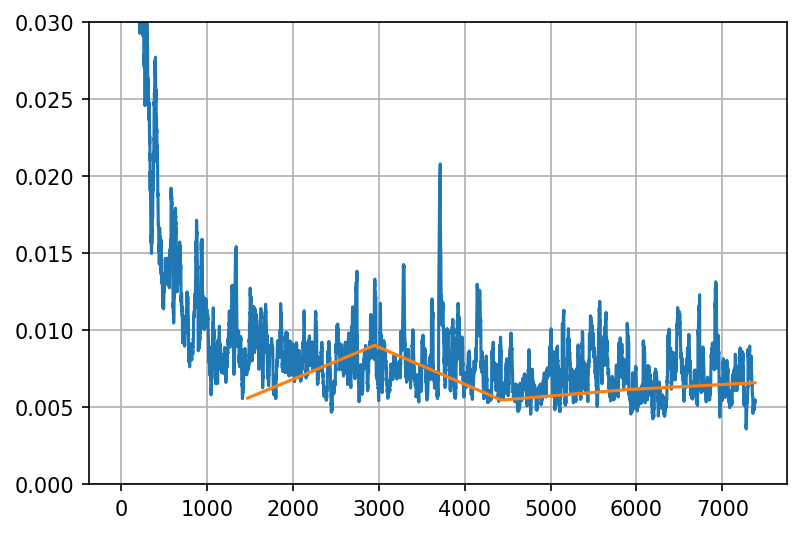

In [13]:
plot_loss_epoch(losses_show, val_losses)

### Testing using n in, 1 out


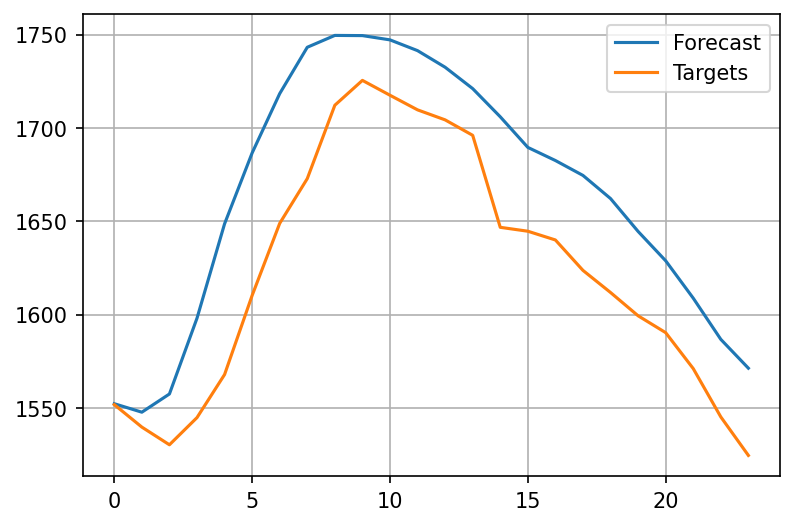

In [14]:
import copy

from matplotlib import pyplot as plt

start_point = 1500
tw = 100
fw = 24

historic_data = list(df_test.copy(deep=True)["consumption"])[
    start_point : start_point + tw + fw
]  # test data from start point to 24 hours after sequence end
targets = copy.deepcopy(historic_data)[
    tw : tw + fw
]  # targets are the last 24 rows of the historic data

predictions = []

for i in range(fw):
    x = np.array(historic_data[i : tw + i]).reshape(
        -1, 1
    )  # input sequence (without the last 24)

    x = torch.Tensor(x).unsqueeze(0).to(device)
    pred = model(x)  # this is the 1 out used in next input

    predictions.append(pred.item())

    historic_data[-fw + i] = (
        pred.item()
    )  # append the prediction to the historic data to be used for next prediction

predictions = (
    np.array(predictions) * train_std["consumption"] + train_mean["consumption"]
)
targets = np.array(targets) * train_std["consumption"] + train_mean["consumption"]

x = range(predictions.shape[0])
plt.figure(figsize=(6, 4), dpi=150)
plt.plot(x, predictions, label="Forecast")
plt.plot(x, targets, label="Targets")
plt.legend()
plt.grid()
plt.show()